10. Real-Time Match Insights
Goal: Provide real-time analytics for ongoing matches.


Steps:
Use the API's live game data endpoint to fetch in-game statistics.
Provide potential winrate based on Blue/Red team's gold, item, levels, objectives etc. 

In [1]:
match_data_list = []
#each csv holds around 600 games of data.
#"iron_data.csv"
#"bronze_data.csv"
#"silver_data.csv"
#"gold_data.csv"
#"platinum_data.csv"
#"emerald_data.csv"
#"diamond_data.csv"
#"master_data.csv"
#"grandmaster_data.csv"
#"challenger_data.csv"

In [2]:
print(len(match_data_list))

0


Function to get relevant data from matches for all ranks effective.(Iron IV - Challenger)

In [4]:
import time
import requests
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

session = requests.Session()
api_key = "RGAPI-1a3f4ab7-cfed-410b-b427-5ee6e7c81755"

#Helper function to handle requests to the API
def make_request(url):
    while True:
        resp = session.get(url)
        if resp.status_code == 429:
            retry_after = int(resp.headers.get("Retry-After", 5))
            print(f"Rate limit exceeded. Retrying after {retry_after} seconds...")
            time.sleep(retry_after)  # Wait before retrying
        elif resp.status_code == 200:
            return resp.json()
        else:
            print(f"Error: {resp.status_code} - {resp.text}")
            return None


# Get Challenger players


def getMatchData(rank, division):
    contributions = ( 'firstTurretKilled', 'goldPerMinute', 'kda', 'teamBaronKills', 'turretTakedowns', 'takedowns', 'teamRiftHeraldKills')
    other_contr = ('champLevel', 'inhibitorKills', 'goldSpent', 'turretKills', 'win', 'dragonKills')
    if rank in ['challenger', 'grandmaster', 'master']:
        rank_api_url = f'https://na1.api.riotgames.com/lol/league/v4/{rank}leagues/by-queue/RANKED_SOLO_5x5?api_key={api_key}'
    else:
        rank_api_url = f'https://na1.api.riotgames.com/lol/league/v4/entries/RANKED_SOLO_5x5/{rank}/{division}?page=1&api_key={api_key}'
        
    rank_data = make_request(rank_api_url)
    if isinstance(rank_data, dict):  
        players = rank_data['entries']  # For challenger, grandmaster, master
    elif isinstance(rank_data, list):
        players = rank_data  # For diamond and below
    total_players = len(players)
    for i, player in enumerate(players):
        while True:  
            try:
                summoner_id = player['summonerId']
                puuid_url = f'https://na1.api.riotgames.com/lol/summoner/v4/summoners/{summoner_id}?api_key={api_key}'
                puuid_data = make_request(puuid_url)
                if puuid_data:
                    puuid = puuid_data['puuid']
                    summoner_url = f'https://americas.api.riotgames.com/riot/account/v1/accounts/by-puuid/{puuid}?api_key={api_key}'
                    summoner_url_1 = requests.get(summoner_url)
                    summoner_name = make_request(summoner_url)['gameName']
    
                    # Retrieve match history
                    match_url = f"https://americas.api.riotgames.com/lol/match/v5/matches/by-puuid/{puuid}/ids?queue=420&type=ranked&start=0&count=20&api_key={api_key}"
                    match_data = make_request(match_url)
    
                    if match_data:
                        for match_id in match_data:
                            match_details_url = f"https://americas.api.riotgames.com/lol/match/v5/matches/{match_id}?api_key={api_key}"
                            match_details = make_request(match_details_url)
                            blue_data = {}
                            red_data = {}
                            combined = {}
                            
                            
                            for other in other_contr:
                                if other == 'win':
                                    blue_data[other] = 0
                                    red_data[other] = 0
                                else:
                                    blue_data['blue' + other ] = 0
                                    red_data['red' + other] = 0
                            
                            for details in contributions:
                                blue_data['blue' + details] = 0
                                red_data['red' + details] = 0
                            
                            if match_details:
                                #print(f"\n📜 Match ID: {match_id}")
                                print(len(match_data_list))
                                for participant in match_details['info']['participants']:
                                    teamId = (participant['teamId'])
                                    winner = participant['win']
                                        
                                    for other in other_contr:
                                        if teamId == 100:
                                            if other == 'win' and winner == 1:
                                                blue_data[other] += 1
                                            elif other == 'win' and winner == 0:                       
                                                blue_data[other] = 0
                                            else:
                                                blue_data['blue' + other] += participant.get(other, 0)
                                        else:
                                            if teamId == 200:
                                                if other == 'win' and winner == 1:
                                                    red_data[other] = 0
                                                elif other == 'win' and (winner == 0):                       
                                                    red_data[other] += 1
                                                else:
                                                    red_data['red' + other] += participant.get(other, 0)
                                        
                                        
                                    for details in contributions:
                                        if teamId == 100:
                                            blue_data['blue' + details] += participant['challenges'].get(details, 0)
                                        else:
                                            red_data['red' + details] += participant['challenges'].get(details, 0)
                                            
                                for key in blue_data.keys():
                                    blue_data[key] /= 5
                                for key in red_data.keys():
                                    red_data[key] /= 5
                                    
                            combined = {**red_data, **blue_data} 

                            
                            #scale up objectives
                            combined['blueteamBaronKills'] *= 15
                            combined['blueturretKills'] *= 5
                            combined['bluedragonKills'] *= 8
                            combined['blueinhibitorKills'] *= 10
                            combined['blueteamRiftHeraldKills'] *= 5


                            
                            combined['redteamBaronKills'] *= 15
                            combined['redturretKills'] *= 5
                            combined['reddragonKills'] *= 8
                            combined['redinhibitorKills'] *= 10
                            combined['redteamRiftHeraldKills'] *= 5

                            
                            # Save match data
                            match_data_list.append(combined)
                    time.sleep(1) 
                    break 
    
            except Exception as e:
                print(f"Error processing player {player['summonerId']}: {e}. Retrying...")
                time.sleep(5) 



#getMatchData('IRON', 'I')


Visualization to see which features contribute more to a loss/win. Tells me what features to use or not use. 

In [5]:
#df = pd.DataFrame(match_data_list)
#df.to_csv("iron_data.csv", index=False)

In [6]:
df_loaded = pd.read_csv("iron_data.csv")
print(df_loaded.head())

   redchampLevel  redinhibitorKills  redgoldSpent  redturretKills  win  \
0           16.6                8.0       12220.0             7.0  0.0   
1           15.2                4.0       11212.0             9.0  0.0   
2           15.8                0.0       12071.0             4.0  1.0   
3            2.2                0.0         500.0             0.0  0.0   
4           15.4                0.0       11309.6             3.0  1.0   

   reddragonKills  redfirstTurretKilled  redgoldPerMinute    redkda  \
0             4.8                   1.0        413.955195  4.492857   
1             4.8                   1.0        448.438275  7.043333   
2             1.6                   1.0        342.666545  3.122424   
3             0.0                   0.0        318.755228  0.400000   
4             4.8                   0.0        355.459857  2.032929   

   redteamBaronKills  ...  bluegoldSpent  blueturretKills  bluedragonKills  \
0               15.0  ...        10957.0          

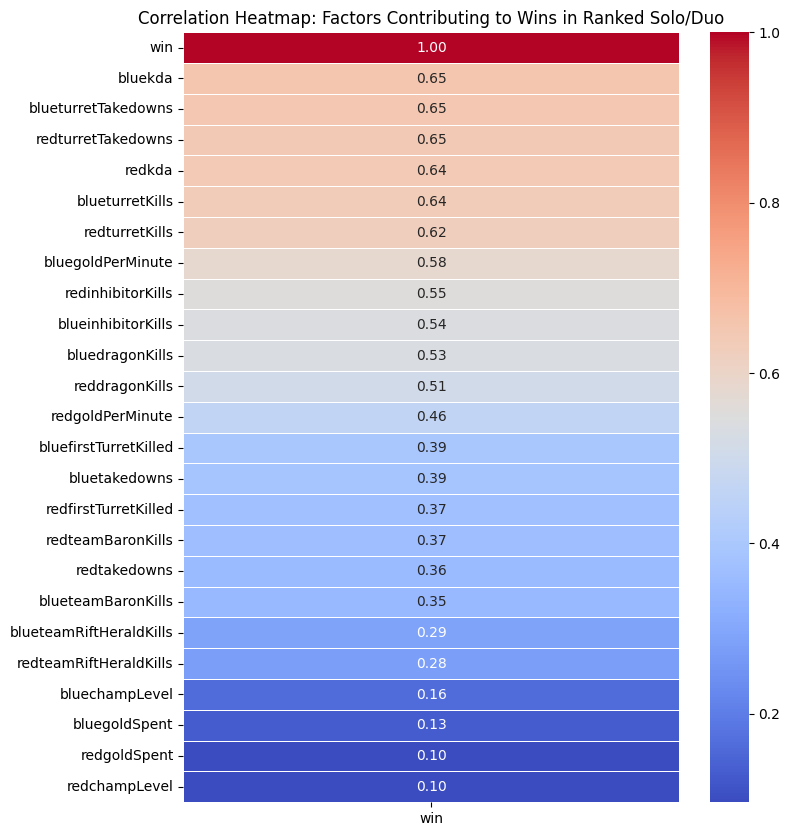

In [7]:
def create_correlation_heatmap():
    """Generates a heatmap showing correlation between different factors and winning."""
    df = pd.DataFrame(df_loaded)
    
    df['win'] = df['win'].astype(float)
    
    # Compute correlation 
    correlation_matrix = df.corr()[["win"]].abs().sort_values(by="win", ascending=False)

    # Plot heatmap
    plt.figure(figsize=(8, 10))  
    sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
    plt.title("Correlation Heatmap: Factors Contributing to Wins in Ranked Solo/Duo")
    plt.show()

create_correlation_heatmap()

Test to see how accurate the models are.

In [31]:
from sklearn.metrics import log_loss
logloss = log_loss(y_test, y_proba)
print(f"Log Loss: {logloss:.4f}")  

Log Loss: 0.0541


Function to get live game data(Averaging the stats for both blue/red team).

In [9]:
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

def live_game_data():
    game_data = []
    match_data_list = []
    features = {}
    
    url = 'https://127.0.0.1:2999/liveclientdata/allgamedata'
    response = requests.get(url, verify = False)
    live_data = response.json()
    
    curr_playerurl = 'https://127.0.0.1:2999/liveclientdata/activeplayername'
    curr_response = requests.get(curr_playerurl, verify = False)
    curr_player = curr_response.json()
    
    version_url = 'https://ddragon.leagueoflegends.com/api/versions.json'
    versions = requests.get(version_url).json()
    latest_version = versions[0]
    
    item_url = f'https://ddragon.leagueoflegends.com/cdn/{latest_version}/data/en_US/item.json'
    item_data = requests.get(item_url).json()

    team_color = ''
    blueteamItem = []
    redteam = []
    redteamItem = []
    blueteam = []
    
    bluekda = 0
    bluegoldPerMin = 0 
    blueturrets = 0
    blueturretTakedowns = 0
    bluekillingSprees = 0
    blueinhibs = 0
    bluedragonKills = 0 
    bluedragonTakedowns = 0 
    bluetakedowns = 0 
    bluegoldSpent = 0
    bluefirsttower = 0 
    bluebarons = 0 
    bluelevel = 0  
    blueherald = 0

    redkda = 0
    redgoldPerMin = 0 
    redturrets = 0
    redturretTakedowns = 0
    redkillingSprees = 0
    redinhibs = 0
    reddragonKills = 0 
    reddragonTakedowns = 0 
    redtakedowns = 0 
    redgoldSpent = 0
    redfirsttower = 0 
    redbarons = 0 
    redlevel = 0  
    redherald = 0
    
    #append team members to list

    for player_team in live_data['allPlayers']:
        if player_team['team'] == 'ORDER':
            blueteam.append(player_team['riotIdGameName'])
            blueteamItem.append(player_team['riotId'])
        else:
            redteam.append(player_team['riotIdGameName'])
            redteamItem.append(player_team['riotId'])

        
            

    #calculate avg KDA
    for players in live_data['allPlayers']:       
        if players['riotIdGameName'] in blueteam:
            currkda = 0
            currkda += (players['scores']['assists'])
            currkda += (players['scores']['kills'])
            if players['scores']['deaths'] == 0:
                bluekda += currkda
            else:
                currkda /= (players['scores']['deaths'])
                bluekda += currkda
        else:
            currkda = 0
            currkda += (players['scores']['assists'])
            currkda += (players['scores']['kills'])
            if players['scores']['deaths'] == 0:
                redkda += currkda
            else:
                currkda /= (players['scores']['deaths'])
                redkda += currkda
            

    #calculate takedowns
    for kd in live_data['allPlayers']:
        if kd['riotIdGameName'] in blueteam:
            kills = 0
            assists = 0
            kills += kd['scores']['kills'] 
            assists += kd['scores']['assists'] 
            bluetakedowns += (kills + assists)
        else:
            kills = 0
            assists = 0
            kills += kd['scores']['kills'] 
            assists += kd['scores']['assists'] 
            redtakedowns += (kills + assists)

    
    #calculating event stats for blue team
    for events in live_data['events']['Events']:
        event = events['EventName']          
        if 'KillerName' in events:           
            killer = events['KillerName']
            if event == 'FirstBrick' and killer in blueteam:
                bluefirsttower = 1 
            elif event == 'TurretKilled' and killer in blueteam:
                blueturrets += 1
                if events['Assisters'] in blueteam:
                    blueturretTakedowns += 1
            elif event == 'InhibKilled' and killer in blueteam:
                blueinhibs += 1
            elif event == 'DragonKill' and killer in blueteam:
                bluedragonKills += 1
                if events['Assisters'] in blueteam:
                    bluedragonTakedowns += 1
            elif event == 'HeraldKill' and killer in blueteam:
                blueherald = 1
            elif event == 'BaronKill' and killer in blueteam:
                bluebarons += 1
    #calculating event stats for red team
    for events in live_data['events']['Events']:
        event = events['EventName']          
        if 'KillerName' in events:           
            killer = events['KillerName']
            if event == 'FirstBrick' and killer in redteam:
                redfirsttower = 1 
            elif event == 'TurretKilled' and killer in redteam:
                redturrets += 1
                if events['Assisters'] in redteam:
                    redturretTakedowns += 1
            elif event == 'InhibKilled' and killer in redteam:
                redinhibs += 1
            elif event == 'DragonKill' and killer in redteam:
                reddragonKills += 1
                if events['Assisters'] in redteam:
                    reddragonTakedowns += 1
            elif event == 'HeraldKill' and killer in redteam:
                redherald = 1
            elif event == 'BaronKill' and killer in redteam:
                redbarons += 1

 
    #calculate avg level and gold for blue team
    for dat in live_data['allPlayers']:
        if dat['riotId'] in blueteamItem:
            #get levels of all players on team
            bluelevel += dat['level']
            summonerName = dat['riotId']
            #get gold values of all players on the team
            
            url = 'https://127.0.0.1:2999/liveclientdata/playeritems?riotId=' + summonerName
            response = requests.get(url, verify = False)    
            data = response.json()
            total = 0
            for y in dat['items']:     
                #calculate price of items per team member
                bluegoldSpent +=  item_data['data'][str(y['itemID'])]['gold']['total']

                    
                #calculate avg gold besides items
            calcGold = 0
            if (live_data['gameData']['gameTime']) < 110:
                calcGold = 500
                bluegoldPerMin += 500/((live_data['gameData']['gameTime'])/60)
            else:
                calcGold += (dat['scores']['creepScore'] * 22) #calculate minion gold
                calcGold += ((live_data['gameData']['gameTime'] - 110) * 2.5) #calculate passive gold
                calcGold += dat['scores']['kills'] * 300 + dat['scores']['assists'] * 150 #calculate kill/assist gold
                calcGold += blueturrets * 300 + bluebarons * 300 #calculate tower and objective gold
                
                
                if bluegoldSpent > calcGold:
                    bluegoldPerMin = bluegoldSpent / ((live_data['gameData']['gameTime'])/60)
                else:                 
                    calcGold = calcGold - bluegoldSpent + 500#(starting money)  unspent avg money              
                    bluegoldPerMin += (bluegoldSpent + calcGold)/ ((live_data['gameData']['gameTime'])/60) #avg gold in a minute
                    
                    
    #calculate avg level and gold for red team
    for dat in live_data['allPlayers']:
        if dat['riotId'] in redteamItem:
            #get levels of all players on team
            redlevel += dat['level']
            summonerName = dat['riotId']
            #get gold values of all players on the team
            
            url = 'https://127.0.0.1:2999/liveclientdata/playeritems?riotId=' + summonerName
            response = requests.get(url, verify = False)    
            data = response.json()
            total = 0
            for y in dat['items']:     
                #calculate price of items per team member  
                redgoldSpent +=  item_data['data'][str(y['itemID'])]['gold']['total']

                    
                #calculate avg gold besides items
            calcGold = 0
            if (live_data['gameData']['gameTime']) < 110:
                calcGold = 500
                redgoldPerMin += 500/((live_data['gameData']['gameTime'])/60)
            else:
                calcGold += (dat['scores']['creepScore'] * 22) #calculate minion gold
                calcGold += ((live_data['gameData']['gameTime'] - 110) * 2.5) #calculate passive gold
                calcGold += dat['scores']['kills'] * 300 + dat['scores']['assists'] * 150 #calculate kill/assist gold
                calcGold += redturrets * 300 + redbarons * 300 #calculate tower and objective gold
                if redgoldSpent > calcGold:
                    redgoldPerMin = redgoldSpent / ((live_data['gameData']['gameTime'])/60)
                else:                 
                    calcGold = calcGold - redgoldSpent + 500#(starting money)  unspent avg money              
                    redgoldPerMin += (redgoldSpent + calcGold)/ ((live_data['gameData']['gameTime'])/60) #avg gold in a minute


    features['redchampLevel'] = redlevel  / len(redteam)
    features['redinhibitorKills'] = redinhibs /  len(redteam)
    features['redgoldSpent'] = redgoldSpent  / len(redteam)
    features['redturretKills'] = redturrets/ len(redteam)
    features['reddragonKills'] = reddragonKills  / len(redteam)
    features['redfirstTurretKilled'] = redfirsttower
    features['redgoldPerMinute'] = redgoldPerMin / len(redteam)
    features['redkda'] = redkda /len(redteam)
    features['redteamBaronKills'] = redbarons  / len(redteam)
    features['redturretTakedowns'] = redturretTakedowns/ len(redteam)
    features['redtakedowns'] = redtakedowns  / len(redteam)
    features['redteamRiftHeraldKills'] = redherald 
    
    features['bluechampLevel'] = bluelevel  / len(blueteam)
    features['blueinhibitorKills'] = blueinhibs /  len(blueteam)
    features['bluegoldSpent'] = bluegoldSpent  / len(blueteam)
    features['blueturretKills'] = blueturrets/ len(blueteam)
    features['bluedragonKills'] = bluedragonKills  / len(blueteam)
    features['bluefirstTurretKilled'] = bluefirsttower
    features['bluegoldPerMinute'] = bluegoldPerMin / len(blueteam)
    features['bluekda'] = bluekda /len(blueteam)
    features['blueteamBaronKills'] = bluebarons  / len(blueteam)
    features['blueturretTakedowns'] = blueturretTakedowns/ len(blueteam)
    features['bluetakedowns'] = bluetakedowns  / len(blueteam)
    features['blueteamRiftHeraldKills'] = blueherald 

    
    #scale up objectives
    features['blueteamBaronKills'] *= 15
    features['blueturretKills'] *= 5
    features['bluedragonKills'] *= 8
    features['blueinhibitorKills'] *= 10
    features['blueteamRiftHeraldKills'] *= 5
                          
    features['redteamBaronKills'] *= 15
    features['redturretKills'] *= 5
    features['reddragonKills'] *= 8
    features['redinhibitorKills'] *= 10
    features['redteamRiftHeraldKills'] *= 5

    #calculate avg goldEarned
    game_data.append(features)
    
    return(game_data)


Gets the prediction for both teams and provides a graphic to help visualize 

In [28]:
import matplotlib.pyplot as plt
import pandas as pd
import time

def getPrediction(minutes, seconds):
    # Initial setup
    from sklearn.model_selection import train_test_split
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.metrics import accuracy_score
    curr_playerurl = 'https://127.0.0.1:2999/liveclientdata/activeplayername'
    curr_response = requests.get(curr_playerurl, verify = False)
    curr_player = curr_response.json()

    name, tag = curr_player.split('#')

    get_puuidurl = f'https://americas.api.riotgames.com/riot/account/v1/accounts/by-riot-id/{name}/{tag}?api_key={api_key}'
    puuidurl_response = requests.get(get_puuidurl, verify = False)
    puuid = puuidurl_response.json()

    encryptpid = puuid['puuid']  

    get_rankurl = f'https://na1.api.riotgames.com/lol/league/v4/entries/by-puuid/{encryptpid}?api_key={api_key}'
    rankurl_response = requests.get(get_rankurl, verify = False)
    rank = rankurl_response.json()
    
    playerrank = rank[0]['tier'].lower()

    #making model
    df_loaded = pd.read_csv(playerrank + '_data.csv')
    
    X = df_loaded.drop(columns=['win'])  
    y = df_loaded['win']
    
    # split into training & testing sets (80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    ##
    
    rf_model = RandomForestClassifier(n_estimators=250, random_state=20)
    rf_model.fit(X_train, y_train)
    

    
    initial_df = pd.DataFrame([live_game_data()[0]])
    probabilities = rf_model.predict_proba(initial_df)[0]
    
    labels = ["Red Win%", "Blue Win%"]
    colors = ["Red", "Blue"]
    plt.ion()
    fig, ax = plt.subplots()
    bars = ax.bar(labels, probabilities, color=colors)
    text_labels = []
    
    for i, bar in enumerate(bars):
        text = ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                       f"{probabilities[i]:.1%}", ha='center', va='bottom', fontsize=12)
        text_labels.append(text)
    
    ax.set_ylabel("Win Probability")
    ax.set_ylim(0, 1)
    ax.set_title(f"Predicted Win Probability at {minutes} minutes {seconds} seconds")
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    plt.show()



Runs every minute to show a visualization and updates predictions based on current data. 

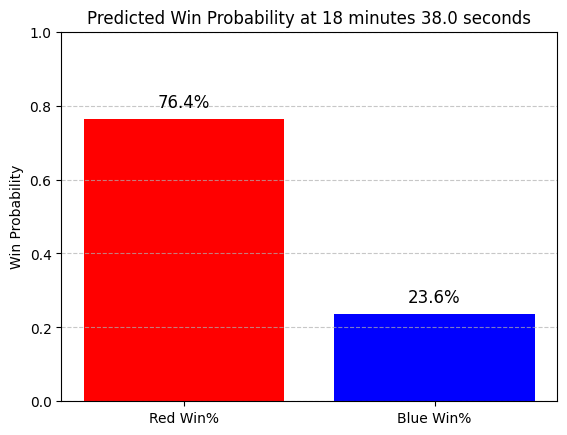

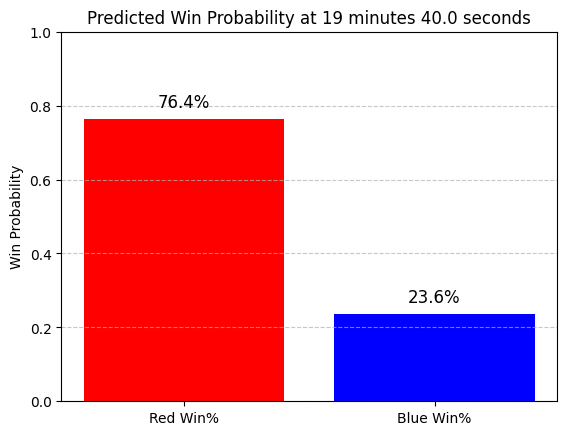

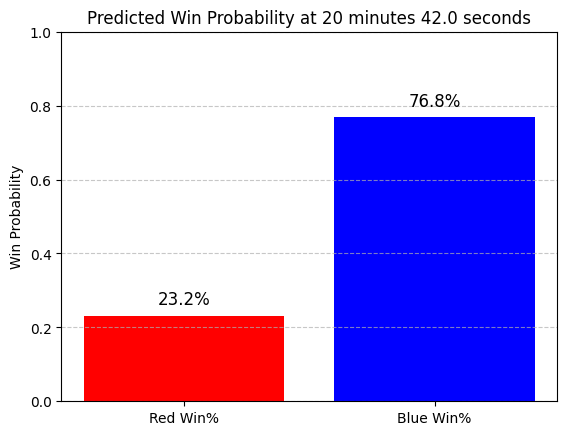

Game not in progress.


In [30]:
import time
import requests
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

def is_game_active():
    try:
        response = requests.get('https://127.0.0.1:2999/liveclientdata/allgamedata', verify=False)
        if response.status_code == 200:
            data = response.json()
            return True  
        else:
            return False
    except:
        return False



while is_game_active():    
    try:
        url = 'https://127.0.0.1:2999/liveclientdata/allgamedata'
        response = requests.get(url, verify = False)
        live_data = response.json() 
        total_seconds = (live_data['gameData']['gameTime'])
        minutes = int(total_seconds // 60)
        seconds = total_seconds % 60
        getPrediction(minutes, round(seconds, 0))
        time.sleep(60) 
    except KeyboardInterrupt:
        print("Stopped by user.")
        break
    except Exception as e:
        print(f"An error occurred: {e}")
        time.sleep(60)

print("Game not in progress.")